# Insurance Portfolio EDA

This notebook performs a comprehensive exploratory data analysis (EDA) of the historical insurance dataset (`MachineLearningRating_v3.txt`). It focuses on portfolio structure, data quality, loss ratio behavior, temporal trends, and risk segmentation signals.


In [11]:
import os
from pathlib import Path
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("tab10")

# Resolve project root robustly so it works whether the CWD is the project root or the notebooks folder
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "data").exists():
    # If we're inside notebooks/, step one level up
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PATH = PROJECT_ROOT / "data" / "MachineLearningRating_v3.txt"

DATA_PATH, DATA_PATH.exists()


(WindowsPath('C:/Users/HomePC/Desktop/Fourth/End-to-End-Insurance-Risk-Analytics-Predictive-Modeling/data/MachineLearningRating_v3.txt'),
 True)

In [13]:
# Peek at the raw file to understand its structure

with open(DATA_PATH, "r", encoding="utf-8", errors="ignore") as f:
    lines = [next(f) for _ in range(10)]

print("\n".join([line.rstrip("\n") for line in lines]))


UnderwrittenCoverID|PolicyID|TransactionMonth|IsVATRegistered|Citizenship|LegalType|Title|Language|Bank|AccountType|MaritalStatus|Gender|Country|Province|PostalCode|MainCrestaZone|SubCrestaZone|ItemType|mmcode|VehicleType|RegistrationYear|make|Model|Cylinders|cubiccapacity|kilowatts|bodytype|NumberOfDoors|VehicleIntroDate|CustomValueEstimate|AlarmImmobiliser|TrackingDevice|CapitalOutstanding|NewVehicle|WrittenOff|Rebuilt|Converted|CrossBorder|NumberOfVehiclesInFleet|SumInsured|TermFrequency|CalculatedPremiumPerTerm|ExcessSelected|CoverCategory|CoverType|CoverGroup|Section|Product|StatutoryClass|StatutoryRiskType|TotalPremium|TotalClaims
145249|12827|2015-03-01 00:00:00|True|  |Close Corporation|Mr|English|First National Bank|Current account|Not specified|Not specified|South Africa|Gauteng|1459|Rand East|Rand East|Mobility - Motor|44069150|Passenger Vehicle|2004|MERCEDES-BENZ|E 240|6|2597|130|S/D|4|6/2002|119300|Yes|No|119300|More than 6 months||||||0.01|Monthly|25|Mobility - Windscreen

In [14]:
# Load dataset

col_types = {
    "UnderwrittenCoverID": "int64",
    "PolicyID": "int64",
    "TransactionMonth": "string",
}

df = pd.read_csv(
    DATA_PATH,
    sep="|",
    dtype=col_types,
    parse_dates=["TransactionMonth"],
)

df.shape, df.dtypes.head(15)


C:\Users\HomePC\AppData\Local\Temp\ipykernel_2304\4168611518.py:9: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


((1000098, 52),
 UnderwrittenCoverID             int64
 PolicyID                        int64
 TransactionMonth       datetime64[ns]
 IsVATRegistered                  bool
 Citizenship                    object
 LegalType                      object
 Title                          object
 Language                       object
 Bank                           object
 AccountType                    object
 MaritalStatus                  object
 Gender                         object
 Country                        object
 Province                       object
 PostalCode                      int64
 dtype: object)

In [15]:
# Basic data understanding

display(df.head())
print("\nInfo:")
print(df.info())

print("\nMissing values (top 20 columns):")
missing = df.isna().sum().sort_values(ascending=False)
missing.head(20)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   UnderwrittenCoverID       1000098 non-null  int64         
 1   PolicyID                  1000098 non-null  int64         
 2   TransactionMonth          1000098 non-null  datetime64[ns]
 3   IsVATRegistered           1000098 non-null  bool          
 4   Citizenship               1000098 non-null  object        
 5   LegalType                 1000098 non-null  object        
 6   Title                     1000098 non-null  object        
 7   Language                  1000098 non-null  object        
 8   Bank                      854137 non-null   object        
 9   AccountType               959866 non-null   object        
 10  MaritalStatus             991839 non-null   object        
 11  Gender                    990562 non-null  

NumberOfVehiclesInFleet    1000098
CrossBorder                 999400
CustomValueEstimate         779642
Rebuilt                     641901
Converted                   641901
WrittenOff                  641901
NewVehicle                  153295
Bank                        145961
AccountType                  40232
Gender                        9536
MaritalStatus                 8259
VehicleType                    552
make                           552
mmcode                         552
Model                          552
Cylinders                      552
bodytype                       552
kilowatts                      552
NumberOfDoors                  552
VehicleIntroDate               552
dtype: int64

In [16]:
# Create engineered metrics

# Ensure numeric types
for col in ["TotalPremium", "TotalClaims", "SumInsured", "CustomValueEstimate"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Portfolio-level loss ratio
if {"TotalPremium", "TotalClaims"}.issubset(df.columns):
    df["LossRatio"] = df["TotalClaims"] / df["TotalPremium"].replace(0, np.nan)
else:
    df["LossRatio"] = np.nan

portfolio_lr = df["TotalClaims"].sum() / df["TotalPremium"].sum()
portfolio_lr


np.float64(1.0477452570332206)

In [17]:
# Data quality checks

quality_report = {}

quality_report["rows"] = len(df)
quality_report["columns"] = df.shape[1]
quality_report["duplicate_rows"] = df.duplicated().sum()

# Basic anomaly flags
for col in ["TotalPremium", "TotalClaims", "SumInsured"]:
    if col in df.columns:
        quality_report[f"{col}_negative"] = (df[col] < 0).sum()
        quality_report[f"{col}_zero"] = (df[col] == 0).sum()

pd.Series(quality_report)


rows                     1000098
columns                       53
duplicate_rows                 0
TotalPremium_negative        288
TotalPremium_zero         381634
TotalClaims_negative           5
TotalClaims_zero          997305
SumInsured_negative            0
SumInsured_zero                0
dtype: int64

In [18]:
# Descriptive statistics for key continuous variables

num_cols = [c for c in ["TotalPremium", "TotalClaims", "SumInsured", "CustomValueEstimate"] if c in df.columns]

df[num_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
TotalPremium,1000098.0,61.905496,2.302845e+02,-782.576754,0.00,0.00,0.0,2.178333,21.929825,4.048780e+02,7.786982e+02,6.528260e+04
TotalClaims,1000098.0,64.861190,2.384075e+03,-12002.412281,0.00,0.00,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,3.930921e+05
SumInsured,1000098.0,604172.732589,1.508332e+06,0.010000,0.01,0.01,5000.0,7500.000000,250000.000000,5.000000e+06,5.000000e+06,1.263620e+07
CustomValueEstimate,220456.0,225531.129942,5.645157e+05,20000.000000,40000.00,58300.00,135000.0,220000.000000,280000.000000,3.600000e+05,4.500000e+05,2.655000e+07


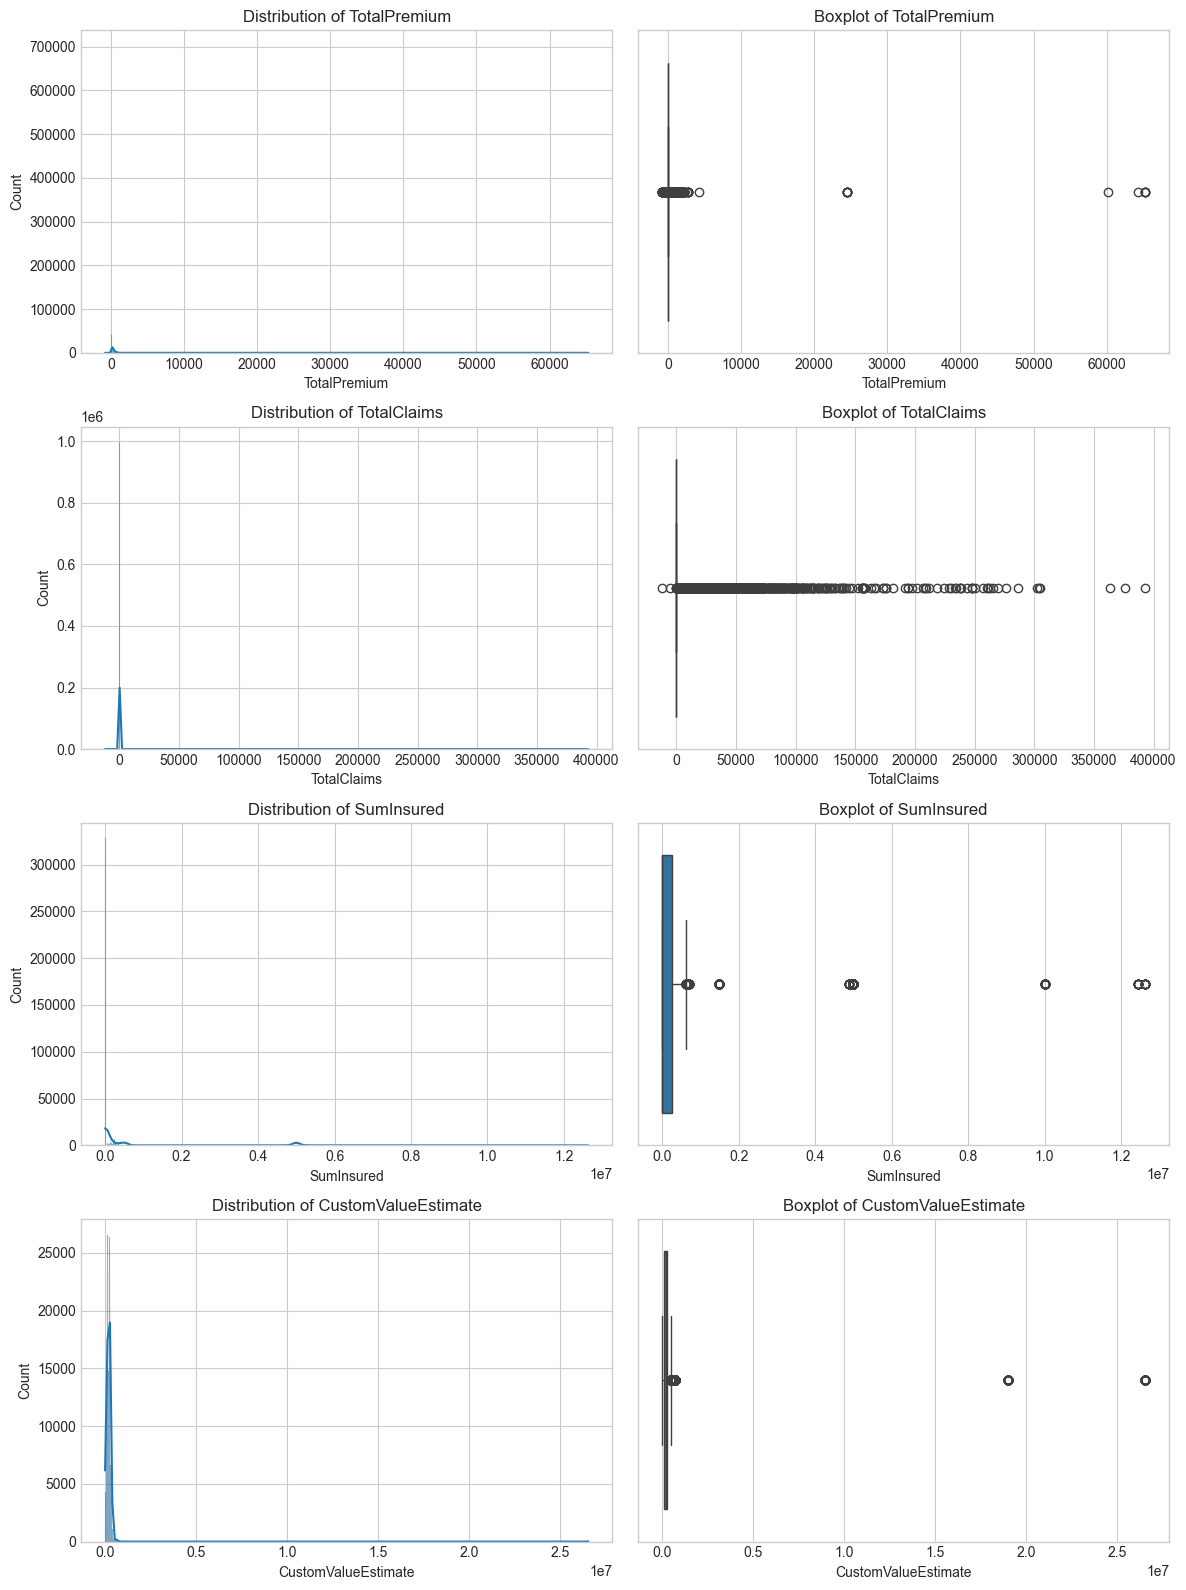

In [19]:
# Univariate distributions for financial variables

fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4 * len(num_cols)))

if len(num_cols) == 1:
    axes = np.array([axes])

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {col}")
    axes[i, 0].set_xlabel(col)

    sns.boxplot(data=df, x=col, ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


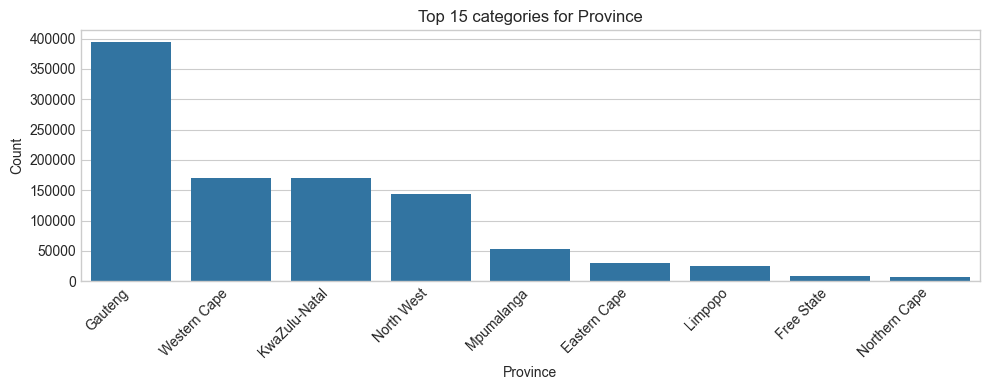

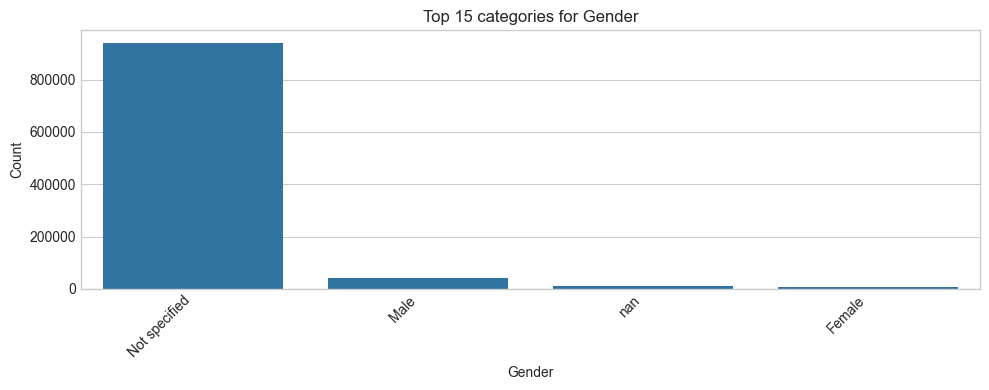

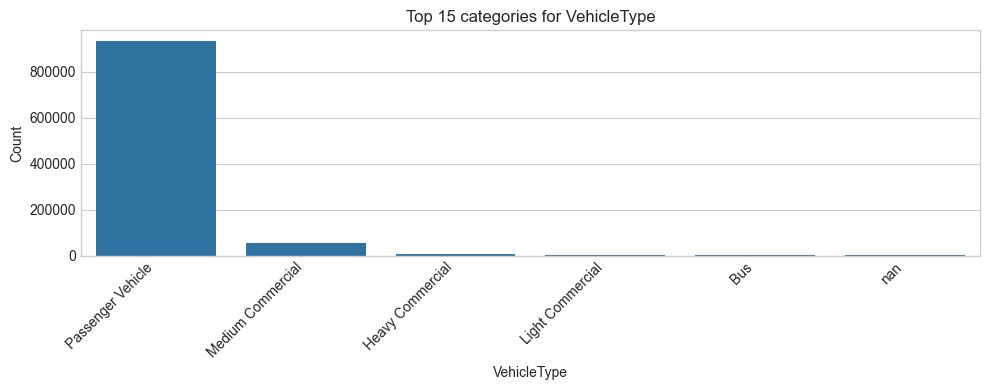

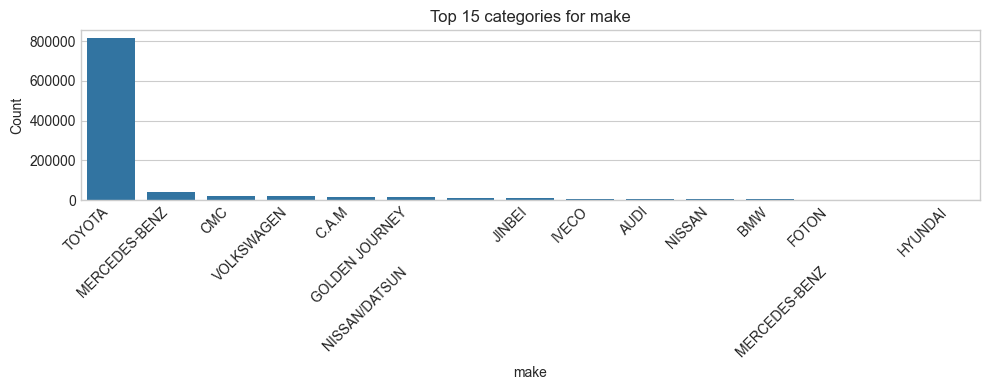

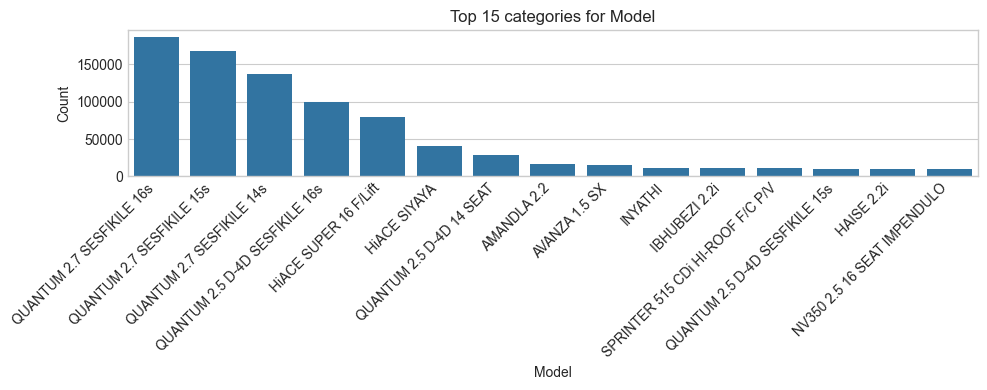

In [20]:
# Categorical frequency distributions

cat_cols = [c for c in ["Province", "Gender", "VehicleType", "make", "Model"] if c in df.columns]

for col in cat_cols:
    plt.figure(figsize=(10, 4))
    counts = df[col].value_counts(dropna=False).head(15)
    sns.barplot(x=counts.index.astype(str), y=counts.values)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Top 15 categories for {col}")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [ ]:
# Bivariate relationships

# Claims vs Premium scatter (log scale to handle skew)
if {"TotalPremium", "TotalClaims"}.issubset(df.columns):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        data=df.sample(min(50000, len(df)), random_state=42),
        x="TotalPremium",
        y="TotalClaims",
        alpha=0.3,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Claims vs Premium (log-log scale)")
    plt.tight_layout()
    plt.show()

# Loss ratio by Province, Gender, VehicleType
for dim in ["Province", "Gender", "VehicleType"]:
    if dim in df.columns and "LossRatio" in df.columns:
        grouped = (
            df.groupby(dim)
            .agg(
                TotalPremium=("TotalPremium", "sum"),
                TotalClaims=("TotalClaims", "sum"),
                Exposure=("UnderwrittenCoverID", "count"),
            )
        )
        grouped["LossRatio"] = grouped["TotalClaims"] / grouped["TotalPremium"].replace(0, np.nan)
        grouped = grouped[grouped["TotalPremium"] > 0].sort_values("LossRatio", ascending=False).head(15)

        plt.figure(figsize=(10, 4))
        sns.barplot(x=grouped.index.astype(str), y=grouped["LossRatio"])
        plt.xticks(rotation=45, ha="right")
        plt.title(f"Loss Ratio by {dim}")
        plt.ylabel("Loss Ratio")
        plt.tight_layout()
        plt.show()


In [ ]:
# Temporal trends: monthly premium, claims, and frequency

if "TransactionMonth" in df.columns:
    df["Month"] = df["TransactionMonth"].dt.to_period("M").dt.to_timestamp()

    monthly = (
        df.groupby("Month")
        .agg(
            TotalPremium=("TotalPremium", "sum"),
            TotalClaims=("TotalClaims", "sum"),
            Policies=("PolicyID", "nunique"),
            Covers=("UnderwrittenCoverID", "count"),
        )
    )
    monthly["LossRatio"] = monthly["TotalClaims"] / monthly["TotalPremium"].replace(0, np.nan)

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    monthly[["TotalPremium", "TotalClaims"]].plot(ax=axes[0])
    axes[0].set_title("Monthly Total Premium and Total Claims")

    monthly["LossRatio"].plot(ax=axes[1], color="crimson")
    axes[1].set_title("Monthly Loss Ratio")

    monthly[["Policies", "Covers"]].plot(ax=axes[2])
    axes[2].set_title("Monthly Policy and Cover Counts")

    plt.tight_layout()
    plt.show()


In [ ]:
# Claim severity distribution by VehicleType and make

if {"VehicleType", "make", "TotalClaims"}.issubset(df.columns):
    # Average claim per cover where there is at least one claim
    severity = (
        df[df["TotalClaims"] > 0]
        .groupby(["VehicleType", "make"])
        .agg(
            AvgClaim=("TotalClaims", "mean"),
            TotalClaimsAmt=("TotalClaims", "sum"),
            Covers=("UnderwrittenCoverID", "count"),
        )
    )
    # Focus on reasonably sized segments
    severity = severity[severity["Covers"] >= 50].sort_values("AvgClaim", ascending=False).head(20)

    plt.figure(figsize=(12, 5))
    sns.barplot(
        data=severity.reset_index(),
        x="make",
        y="AvgClaim",
        hue="VehicleType",
    )
    plt.xticks(rotation=45, ha="right")
    plt.title("Claim Severity (Average Claim) by VehicleType and Make - Top Segments")
    plt.ylabel("Average claim amount")
    plt.tight_layout()
    plt.show()


In [ ]:
# Correlation matrix for numeric variables

corr_cols = [c for c in num_cols + ["LossRatio"] if c in df.columns]

corr = df[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix of key numeric variables")
plt.tight_layout()
plt.show()


## Key Insights and Answers to Guiding Questions

**1. Overall Loss Ratio**  
The portfolio-level loss ratio is computed as total claims divided by total premium (`portfolio_lr` variable). This provides a single headline KPI for the book across the full 18‑month period.

**2. Loss Ratio by Province, VehicleType, and Gender**  
Loss ratios by segment are visualized in the bar charts ("Loss Ratio by Province", "Loss Ratio by Gender", and "Loss Ratio by VehicleType"). These charts highlight which regions and customer/vehicle segments are under‑ or over‑performing relative to the overall portfolio.

**3. Outliers in TotalClaims, TotalPremium, CustomValueEstimate**  
Histograms and boxplots for `TotalPremium`, `TotalClaims`, `SumInsured`, and `CustomValueEstimate` reveal strong right skew and a small number of very large values (high‑severity claims and high‑sum‑insured risks). Negative or zero values are explicitly counted in the data quality section to flag potential data issues or special treatments.

**4. Changes in Claim Frequency/Severity Over Time**  
Monthly trend plots show how premium volume, total claims, loss ratio, and exposure (policy/cover counts) evolve from Feb 2014 to Aug 2015. This allows you to spot any deterioration/improvement in performance, seasonality, or portfolio growth/contraction.

**5. Highest Claim Amounts by Vehicle Make/Model**  
The "Claim Severity by VehicleType and Make" visualization focuses on segments with sufficient volume and ranks them by average claim size. This surfaces high‑severity makes/models (and vehicle types) that may warrant tighter underwriting or pricing.

**6. Early Insights for Risk Segmentation and Pricing Strategy**  
- High‑loss‑ratio provinces or vehicle types suggest segments where rates may be inadequate or risk selection too loose.  
- Very skewed severity distributions imply the need for robust pricing models (e.g., GLMs with appropriate link/variance, or separate frequency and severity models).  
- Time‑varying loss ratio patterns can indicate changes in underwriting standards, external environment, or seasonality and should be controlled for in modeling.  
- Make/model severity differences indicate that granular vehicle attributes are important predictors and should be included in later predictive models.  

This EDA establishes a clear understanding of the dataset’s structure, quality, and key risk drivers, and it provides a statistically grounded basis for subsequent modeling work.
